# Loading data

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
X_full = pd.read_csv('train.csv', index_col='Id')
X_test = pd.read_csv('test.csv', index_col='Id')

y = X_full.pop('SalePrice')
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [36]:
X_full.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, random_state=7)
X_train = X_full
y_train = y

# Cleaning

## Filling missing values

In [38]:
cols_with_missing = [col for col in X_full.columns if X_full[col].isnull().any()]

missing_val_counts = X_full.isnull().sum()
missing_val_counts[missing_val_counts > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Looking at the data description file, we notice that
- Alley, MasVnrType (MasVnrArea), BsmtQual (BsmtCond, BsmtFinType1, BsmtFinType2), FireplaceQu, GarageType (GarageYrBlt, GarageFinish, GarageQual, GarageCond), PoolQC, Fence, MiscFeature use NA as a category. This usually means the house does not have the specified quality.
- LotFrontage, Electrical are the only unaccounted feature here. The file doesn't mention null values for these feature, so it's likely that these are genuinely missing values in the data set.

For LotFrontage and Electrical, it makes sense to impute with either the mean or mode. For the other columns, we should create a new category specifically for non-existence. This is easy to do for categorical columns, but less straightforward for numerical columns that are derived from these associated categorical columns. For instance, what should the GarageYrBlt of a garage that doesn't exist be? It seems safest to just impute the mean for these columns.

In [39]:
missing_val_counts_test = X_test.isnull().sum()
missing_val_counts_test[missing_val_counts_test > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

Checking the test set, we see that there are more featues with missing values compared to the training data.
- MSZoning, Utilities, Exeterior1st (Exterior2nd), KitchenQual, Functional, SaleType make no mention of NA values and probably should be imputed with mean or most frequent values.
- GarageCars, GarageArea are derivative garage columns that didn't have null values in the training sets. It may be possible to calculate these values from the other garage data, assuming those values aren't also null. If they are, we should probably just impute the mean. For now, we'll just do that latter for simplicity.

In [40]:
cols_with_missing_set = set(cols_with_missing)
test_new_missing = [col for col in X_test.columns 
        if X_test[col].isnull().any() and col not in cols_with_missing_set]

### Filling in categorical columns

In [41]:
missing_cat_cols_train = [col for col in cols_with_missing if X_train[col].dtype == 'object' and col != 'Electrical']
missing_cat_cols_test = [col for col in test_new_missing if X_test[col].dtype == 'object']
missing_cat_cols_test

X_train[missing_cat_cols_train] = X_train[missing_cat_cols_train].fillna('none')
X_valid[missing_cat_cols_train] = X_valid[missing_cat_cols_train].fillna('none')
X_test[missing_cat_cols_train] = X_test[missing_cat_cols_train].fillna('none')

X_test[missing_cat_cols_test] = X_test[missing_cat_cols_test].fillna(X_full[missing_cat_cols_test].mode().iloc[0])

In [42]:
# Filling in the electrical feature
X_train.Electrical = X_train.Electrical.fillna(X_train.Electrical.mode().iloc[0])
X_valid.Electrical = X_valid.Electrical.fillna(X_train.Electrical.mode().iloc[0])

### Filling in numerical columns

In [43]:
num_missing_cols_train = [col for col in cols_with_missing if X_train[col].dtype != 'object']
num_missing_cols_test = [col for col in test_new_missing if X_test[col].dtype != 'object']
num_missing_cols = num_missing_cols_train + num_missing_cols_test

print(num_missing_cols_train)
X_test[num_missing_cols] = X_test[num_missing_cols].fillna(X_full[num_missing_cols].mean())
X_train[num_missing_cols_train] = X_train[num_missing_cols_train].fillna(X_train[num_missing_cols_train].mean())
X_valid[num_missing_cols_train] = X_valid[num_missing_cols_train].fillna(X_train[num_missing_cols_train].mean())

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


## Feature engineering
### Mutual information

In [44]:
from sklearn.feature_selection import mutual_info_regression

In [45]:
X_train_mi = X_train.copy()
for col in X_train_mi.select_dtypes('object'):
    X_train_mi[col], _ = X_train_mi[col].factorize()
discrete_features = X_train_mi.dtypes == int

In [46]:
mi_scores = mutual_info_regression(X_train_mi, y_train, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, index=X_train_mi.columns)
mi_scores = mi_scores.sort_values(ascending=False)
pd.set_option('display.max_rows', 70)
pd.options.display.max_rows = 1000
mi_scores[mi_scores > .15]

OverallQual     0.581276
Neighborhood    0.529886
GarageArea      0.497107
GrLivArea       0.432153
YearBuilt       0.408978
TotalBsmtSF     0.396740
LotArea         0.393802
GarageCars      0.359059
ExterQual       0.331609
KitchenQual     0.328788
BsmtQual        0.327300
GarageYrBlt     0.293238
1stFlrSF        0.282052
MSSubClass      0.278948
YearRemodAdd    0.276859
FullBath        0.265040
GarageFinish    0.263565
TotRmsAbvGrd    0.213290
FireplaceQu     0.207535
GarageType      0.205029
LotFrontage     0.202128
Foundation      0.200692
OpenPorchSF     0.187716
HeatingQC       0.168799
Fireplaces      0.166741
2ndFlrSF        0.163594
Exterior2nd     0.160662
BsmtFinType1    0.158058
BsmtFinSF1      0.156238
dtype: float64

This gives us a good list of features to work with. We've arbitarily chosen a cut off of 0.15 mutual information in the above computation.

In [47]:
features = mi_scores[mi_scores > .15].index
mi_scores[features]

X_train = X_train[features]
X_valid = X_valid[features]
X_test = X_test[features]

### Dealing with categorical columns

In [48]:
obj_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
cat_counts = {col: X_train[col].nunique() for col in obj_cols}
sorted(cat_counts.items(), key=lambda x: x[1])

[('ExterQual', 4),
 ('KitchenQual', 4),
 ('GarageFinish', 4),
 ('BsmtQual', 5),
 ('HeatingQC', 5),
 ('FireplaceQu', 6),
 ('Foundation', 6),
 ('GarageType', 7),
 ('BsmtFinType1', 7),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

We notice that Neighborhood has many categories. However, the previous subsection showed that this features has high mutual information, so we shouldn't drop it. Let's examine this feature further before deciding what exactly we should do with it.

In [49]:
X_train.groupby(['Neighborhood']).size()

Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgHt     77
OldTown    113
SWISU       25
Sawyer      74
SawyerW     59
Somerst     86
StoneBr     25
Timber      38
Veenker     11
dtype: int64

There are very few neighborhoods that occur infrequently. That means we won't be able to just one-hot encode the most frequent neighborhoods and ignore the rest.

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 42.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.3% of the points cannot be placed; you may want to decrease the size of the m

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

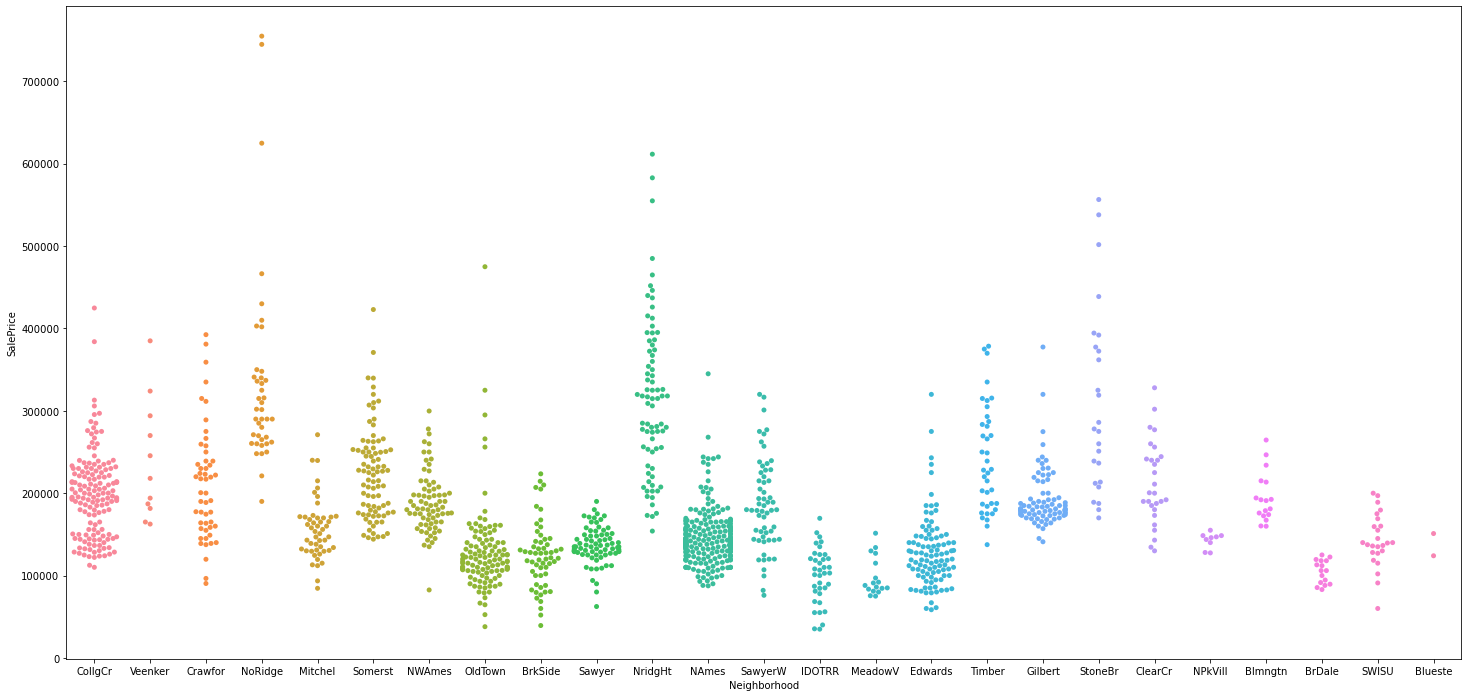

In [50]:
plt.figure(figsize=(25, 12))
sns.swarmplot(x=X_train.Neighborhood, y=y_train)

In lieu of one-hot encoding the Neiborhood feature, we'll opt for using an ordinal encoding based on the mean sale price for that neighborhood.

In [51]:
X_nbr = X_train.assign(SalePrice=y_train)
nbrs_ordered = X_nbr.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index

Many of the other categorical columns lend themselves well to ordinal encoding. In particular, many columns use a quality scale. However, for some of these we added the additional category 'none' for nonexistent attributes. It's not as clear where this category should lie in the ordering.

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 40.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

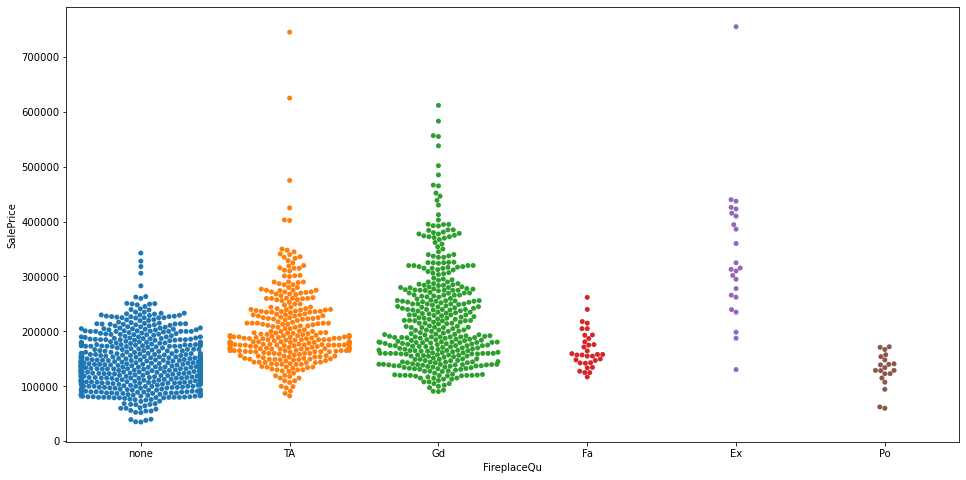

In [52]:
plt.figure(figsize=(16, 8))
sns.swarmplot(x=X_train.FireplaceQu, y=y_train)

The FireplaceQu plot at least indicates that 'none' should be below Po (poor), i.e. it should have the lowest value in the ordering.

The Exterior2nd feature has quite a few categories too. Let's see if we can get away with ordinal encoding it.

/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 40.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3/dist-packages/seaborn/categorical.py:1296: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the 

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

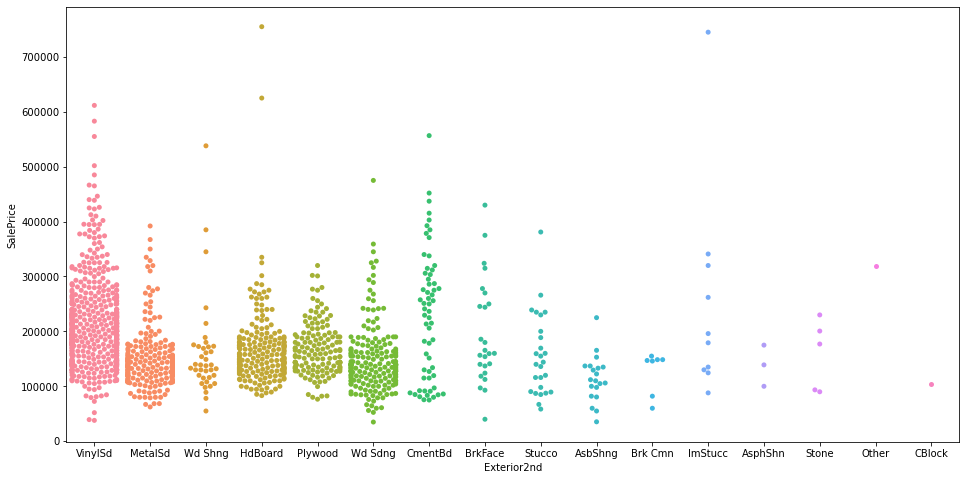

In [53]:
plt.figure(figsize=(16, 8))
sns.swarmplot(x=X_train.Exterior2nd, y=y_train)

In [54]:
ext_ordered = X_nbr.groupby('Exterior2nd')['SalePrice'].mean().sort_values(ascending=False).index

In [55]:
qu_ordered = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'none']
qu_cols = ['ExterQual', 'KitchenQual', 'BsmtQual', 'FireplaceQu']
onehot_cols = ['GarageFinish', 'Foundation', 'GarageType']
ord_cols_misc = ['Neighborhood', 'Exterior2nd']

### Numerical columns
For now, we'll simply scale/shift the numerical columns to standardize our data.

In [56]:
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
        ('qu_ord', OrdinalEncoder(categories=[qu_ordered for _ in range(len(qu_cols))]), qu_cols),
        ('misc_ord', OrdinalEncoder(categories=[nbrs_ordered, ext_ordered]), ord_cols_misc)
    ]
)

# Modeling
## Preliminary modeling

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

In [60]:
models = [LinearRegression(), RandomForestRegressor(random_state=7), XGBRegressor()]
steps = [('preprocessor', preprocessor), None]
pipes = []

for i, model in enumerate(models):
    steps.pop()
    steps.append((f'model[{i}]', model))
    pipes.append(Pipeline(steps=steps.copy()))

In [61]:
from sklearn.model_selection import cross_val_score

In [62]:
for i, pipe in enumerate(pipes):
    scores = -1 * cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    print(f'Model[{i}] score: {scores.mean()}')

Model[0] score: 1256492948.8135686
Model[1] score: 830923768.509643
Model[2] score: 781183742.9790597


## Hyperparameter tuning
### Random forests

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
n_estimators = list(range(50, 350, 50))
min_samples_split = [2, 5, 10, 12]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
         'min_samples_split': min_samples_split,
         'min_samples_leaf': min_samples_leaf,
         'bootstrap': bootstrap
}

In [65]:
rf = RandomForestRegressor(random_state=7)
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=5, n_jobs=-1)

In [66]:
rf_pipe = Pipeline(
    steps=[('cats', preprocessor),
           ('grid', grid_search)]
)

#rf_pipe.fit(X_train, y_train)
#rf_pipe['grid'].best_params_

After 8 minutes, we obtain the hyperparameters
 - 'bootstrap': True,
 - 'min_samples_leaf': 1,
 - 'min_samples_split': 2,
 - 'n_estimators': 300}

In [67]:
rf_hyperparams = {'bootstrap': True,
                  'min_samples_leaf': 1,
                  'min_samples_split': 2,
                  'n_estimators': 300
}

rf_pipe_final = Pipeline(
    steps=[('preprocessor', preprocessor),
            ('rf', RandomForestRegressor(random_state=7, **rf_hyperparams))]
)

scores = -1 * cross_val_score(rf_pipe_final, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
scores.mean()

828795069.2430141

### Gradient boosting

In [68]:
from sklearn.model_selection import RandomizedSearchCV

In [69]:
n_estimators = list(range(100, 1100, 100))
learning_rate = np.arange(.1, .25, 0.05)
min_child_weight = [1, 3, 5, 7, 10]
gamma = [0.5, 1, 1.5, 2, 5, 0.75]
subsample = [0.6, 0.8, 1.0, 0.95]
max_depth = [3, 4, 5]

grid = {'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'max_depth': max_depth
}

In [70]:
xgb = XGBRegressor()
rand_search = RandomizedSearchCV(estimator=xgb, param_distributions=grid, cv=10, n_iter=100, n_jobs=-1)

In [71]:
xgb_pipe = Pipeline(
    steps=[('cat', preprocessor),
           ('grid', rand_search)]
)

#xgb_pipe.fit(X_train, y_train)
#xgb_pipe['grid'].best_params_

In [72]:
grid = {
    'subsample': [0.95],
    'n_estimators': list(range(100, 1100, 50)),
    'min_child_weight': [1],
    'max_depth': [3],
    'learning_rate': [0.04],
    'gamma': [1.25]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=grid, cv=5, n_jobs=-1)

In [73]:
xgb_pipe = Pipeline(
    steps=[('cat', preprocessor),
           ('grid', grid_search)]
)

#xgb_pipe.fit(X_train, y_train)
#xgb_pipe['grid'].best_params_

In [74]:
xgb_hyperparams = {
    'subsample': 0.95,
    'n_estimators': 500,
    'min_child_weight': 1,
    'max_depth': 3,
    'learning_rate': 0.04,
    'gamma': 1.25
}

xgb_pipe_final = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('xgb', XGBRegressor(n_jobs=-1, **xgb_hyperparams))]
)

scores = -1 * cross_val_score(xgb_pipe_final, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
scores.mean()

659846772.4566164

# Creating a submission

In [75]:
xgb_pipe_final.fit(X_train, y_train)
preds = xgb_pipe_final.predict(X_test)
preds
print(len(preds))
print(len(X_test))

1459
1459


In [76]:
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': preds})
output.to_csv('submission.csv', index=False)